In [1]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.tools.retriever import create_retriever_tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/miniconda3/envs/mlops/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
embeddings = HuggingFaceEmbeddings(model='all-MiniLM-L6-v2')

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it")
llm.invoke("Hey how are you doing?")


AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to assist you! How can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 15, 'total_tokens': 47, 'completion_time': 0.058181818, 'prompt_time': 0.001836808, 'queue_time': 1.404396154, 'total_time': 0.060018626}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--ebf64e8a-700a-4d71-be3f-9d22e1a2d1ae-0', usage_metadata={'input_tokens': 15, 'output_tokens': 32, 'total_tokens': 47})

#### Data and Data Source(s)

- Bring in the data source- using Appropriate loaders 
- get the text from the data loader(s)
- run a recursive character text splitter to chunk the text into bits 
- store the chunks into a vector DB (chroma)

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken"
]

In [6]:
''' requires bs4 '''

docs = [WebBaseLoader(url).load() for url in urls]

In [7]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [8]:
docs[0][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [9]:
docs_list = [item for sub_list in docs for item in sub_list]

#### Data and Data Source(s)

- Bring in the data source- using Appropriate loaders 
- get the text from the data loader(s)
- run a 

In [10]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [11]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)

In [12]:
docs_split = text_splitter.split_documents(docs_list)
docs_split[:3]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [13]:
# from chromadb import PersistentClient

# client = PersistentClient(path="./chroma_db")

vectorstore = Chroma.from_documents(
    documents=docs_split,
    collection_name='rag-chrome',
    embedding=embeddings,
    # client=client
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [14]:
retriever = vectorstore.as_retriever()
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x17c3401a0>, search_kwargs={})

In [15]:
''' Creating tools for the Agent '''

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about the Lilian weng blog posts on LLM agents, Prompt engineering, adversarial attacks on LLMs and counting tokens with tiktoken"
)

In [16]:
tools = [retriever_tool]  # always store tools in lists 

DEFINE NODE FUNCTIONS

In [17]:
class AgentState:
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [18]:
def AIAssistant(state: AgentState):
    print("--- CALL AGENT ---")
    messages = state['messages']
    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [21]:
def rewrite(state):
    print("--- TRANSFORM QUERY ---")
    messages = state['messages']
    question = messages[0].content
    
    msg = [
        HumanMessage(
            content=f""" \n
        ""Look at the input and try to reason about the underlying semantic intent / meaning \n
        Here is the initial question:
        \n ------- \n 
        {question} 
        \n ------- \n 
        ""Formulate an improved question: """
        )
    ]
    
    response = llm.invoke(msg)
    return {"messages": [response]}

In [22]:
def generate(state):
    print("--- GENERATE ---")
    messages = state['messages']
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [23]:
class grade(BaseModel):
    binary_score:str = Field(description="Relevance scores 'yes' or 'no' ")

In [24]:
def grade_documents(state:AgentState):
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template="""You are a grader assessing the relevance of a retrieved document to a user question \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or sematic meaning related to related to the user's question and grade it as relevant or irrelevant \n
        give a binary score of 'yes' or 'no' to indicate whether the document is relevent to the question
        """, 
        input_variables=['context', 'question']
    )
    
    chain = prompt | llm_with_structure_op
    messages = state['messages']
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, 'context': docs})
    score = scored_result.binary_score
    
    if score == 'yes':
        print("--- DECISION: DOCS RELEVANT ---")
        return 'generator'
    else:
        print("--- DECISION: DOCS IRRELEVANT ---")
        return 'rewriter'

In [25]:
def retreive(state):
    pass

In [33]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant", AIAssistant)
ToolNode([retriever_tool])
workflow.add_node("retriever", retreive)
workflow.add_node("rewriter", rewrite)
workflow.add_node("generator", generate)

In [34]:
workflow.add_edge(START, 'ai_assistant')
workflow.add_conditional_edges(
    "ai_assistant", 
    tools_condition, 
    {   'tools': "retriever", END: END  }
)

In [35]:
workflow.add_conditional_edges(
    "retriever",
    grade_documents,
    {   "rewriter": "rewriter", "generator": "generator"})

In [36]:
workflow.add_edge('generator', END)
workflow.add_edge('rewriter', 'ai_assistant')

In [37]:
app = workflow.compile()

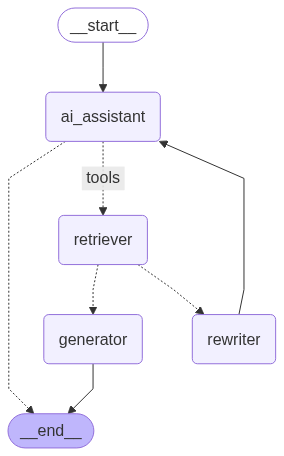

In [38]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
    
except Exception as e:
    print(e)

In [ ]:
app.invoke("?")